In [1]:
import os
import re

import numpy as np
import pandas as pd
import tensorflow as tf

from time import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def load_embedding_weights(text_dir, filename):
    """Loads the word embedding weights from a pre-trained model.
    
    Parameters:
        text_dir: The directory containing the text file with the weights.
        filename: The name of that text file.
        
    Returns:
        vocabulary: A list containing the words in the vocabulary.
        embedding: A numpy array of the weights.
    """
    vocabulary = []
    embedding = []
    with open(os.path.join(text_dir, filename), 'rb') as f:
        for line in f.readlines():
            row = line.strip().split(' ')
            vocabulary.append(row[0])
            embedding.append(map(np.float32, row[1:]))
        embedding = np.array(embedding)
        print('Finished loading word embedding weights.')
    return vocabulary, embedding

text_dir = 'text_model/embedding_weights'
filename = 'glove.6B.50d.txt'
vocabulary, embedding = load_embedding_weights(text_dir, filename)
vocab_size, embedding_dim = embedding.shape
word_to_id = dict(zip(vocabulary, range(vocab_size)))

# Unknown words = vector with zeros
embedding = np.concatenate([embedding, np.zeros((1, embedding_dim))])

Finished loading word embedding weights.


In [3]:
# Convert a string representation of a list such as '[happy, sun, outdoors]'
# to a set of strings {'happy', 'sun', 'outdoors'}
def str_list_to_set(str_list):
    output = str_list[1:-1].split(',')
    output = set([x.strip() for x in output])
    return output

def df_with_hashtag_in_post(df, tag):
    # Make sure that the relevant hashtag is in the post
    df['tags'] = df['tags'].map(str_list_to_set)
    mask = df['tags'].map(lambda x: tag in x)
    return df.loc[mask, :].reset_index(drop=True)

emotions = ['happy', 'sad']#, 'angry', 'scared', 'disgusted', 'surprised']
columns = ['id', 'post_url', 'type', 'timestamp', 'date', 'tags', 'liked',
           'note_count', 'photo', 'text', 'search_query']
df_all = pd.DataFrame(columns=columns)
for emotion in emotions:
    path = os.path.join('data', emotion + '.csv')
    df_emotion = df_with_hashtag_in_post(pd.read_csv(path, encoding='utf-8'), emotion)
    df_all = pd.concat([df_all, df_emotion]).reset_index(drop=True)

In [4]:
_PUNCTUATION = '!"$%&\'()*+,./:;<=>?[\\]^_`{|}~' # string.punctuation with hashtag removed
_MIN_ENGLISH_WORDS_IN_POST = 5

def is_valid_text(paragraph, vocab_set):
    # Check for nan text
    if (type(paragraph) == float) and (np.isnan(paragraph)):
        return False
    else:
        regex = re.compile('[%s]' % re.escape(_PUNCTUATION))
        # Remove punctuation, convert to lower case before splitting
        words = regex.sub('', paragraph).lower().split()
        # Check if there are atleast _MIN_ENGLISH_WORDS_IN_POST words in english
        return len(set(words).intersection(vocab_set)) > _MIN_ENGLISH_WORDS_IN_POST

In [5]:
def preprocess_df(df, vocabulary):
    vocab_set = set(vocabulary)
    mask = df['text'].map(lambda x: is_valid_text(x, vocab_set))
    return df.loc[mask, :].reset_index(drop=True)

df_all = preprocess_df(df_all, vocabulary)
df_all.shape

(157890, 11)

In [6]:
def paragraph_to_ids(paragraph, word_to_id, post_size):
    words = []
    vocab_size = len(word_to_id)
    regex = re.compile('[%s]' % re.escape(_PUNCTUATION))
    # Remove punctuation, convert to lower case before splitting
    words = regex.sub('', paragraph).lower().split()
    # Replace unknown words by an id equal to the size of the vocab
    words = map(lambda x: word_to_id.get(x, vocab_size), words)
        
    if len(words) > post_size:
        words = words[:post_size]
    else:
        words = words + [vocab_size] * (post_size - len(words))
    return words

In [7]:
post_size = 200
df_all['text_list'] = df_all['text'].map(lambda x: paragraph_to_ids(x, word_to_id, post_size))

# Binarise emotions
emotion_dict = dict(zip(emotions, range(len(emotions))))
df_all['search_query'] =  df_all['search_query'].map(emotion_dict)

# Add <ukn> word to dictionary
word_to_id['<ukn>'] = vocab_size

In [118]:
#train_data, valid_data, test_data, word_to_id = ptb_raw_data('data')
id_to_word = {i: k for k, i in word_to_id.iteritems()}
vocab_size = len(word_to_id)
#hidden_size = 200
fc1_size = 2048
batch_size = 128
nb_emotions = len(emotions)
#num_layers = 2 # Number of stacked LSTMs
dropout = 1.0 # Proba to keep neurons
max_grad_norm = 5.0 # Maximum norm of gradient
init_scale = 0.1 # Weights initialization scale
initial_lr = 1e-3
lr_decay = 0.1
max_epoch_no_decay = 2 # Number of epochs not decaying learning rate
nb_epochs = 10 # Maximum number of epochs

In [206]:
tf.reset_default_graph()

input_data = tf.placeholder(tf.int32, [None, post_size])
target = tf.placeholder(tf.int32, [None])
learning_rate = tf.Variable(initial_lr, trainable=False)
# Use a placeholder to turn off dropout during testing 
keep_prob = tf.placeholder(tf.float32)
embedding_placeholder = tf.placeholder(tf.float32, [vocab_size, embedding_dim])
def build_graph():
    # Word embedding
    W_embedding = tf.get_variable('W_embedding', [vocab_size, embedding_dim], trainable=False)
    embedding_init = W_embedding.assign(embedding_placeholder)
    input_embed = tf.nn.embedding_lookup(W_embedding, input_data)
    input_embed_dropout = tf.nn.dropout(input_embed, keep_prob)
    
    # Rescale the mean by the actual number of non-zero values.
    nb_finite = tf.reduce_sum(tf.cast(tf.not_equal(input_embed_dropout, 0.0), tf.float32), axis=1)
    # If a post has zero finite elements, replace nb_finite by 1
    nb_finite = tf.where(tf.equal(nb_finite, 0.0), tf.ones_like(nb_finite), nb_finite)
    h1 = tf.reduce_mean(input_embed_dropout, axis=1) * post_size / nb_finite
    
    # Fully connected layer
    W_fc1 = tf.get_variable('W_fc1', [embedding_dim, fc1_size])
    b_fc1 = tf.get_variable('b_fc1', [fc1_size])
    h2 = tf.matmul(h1, W_fc1) + b_fc1
    h2 = tf.nn.relu(h2)
    
    # Output layer
    W_softmax = tf.get_variable('W_softmax', [fc1_size, nb_emotions])
    b_softmax = tf.get_variable('b_softmax', [nb_emotions])
    logits = tf.matmul(h2, W_softmax) + b_softmax
    #logits = tf.reshape(logits, [batch_size, num_steps, vocab_size])
    # Use sequence loss for average over batch and sum across timesteps
    #loss_vector = tf.contrib.seq2seq.sequence_loss(logits, target, weights=tf.ones([batch_size, num_steps]),
     #                                              average_across_batch=True, average_across_timesteps=False)
    
    labels = tf.one_hot(target, nb_emotions)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits))
    # Use gradient cliping
    trainable_vars = tf.trainable_variables()
    grads, _ = tf.clip_by_global_norm(tf.gradients(loss, trainable_vars), max_grad_norm)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train_step = optimizer.apply_gradients(zip(grads, trainable_vars),
                                           global_step=tf.contrib.framework.get_or_create_global_step())

    correct_pred = tf.equal(tf.cast(tf.argmax(logits, 1), tf.int32), target)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    
    return embedding_init, loss, accuracy, train_step, h1

In [207]:
def run_model(sess, X, y, is_training, lr_decay=0.5, nb_epochs=1, show_loss_graph=True):
    batch_len = X.shape[0] / batch_size
    epoch_size = batch_len
    if is_training:
        # Iteration to print at
        print_iter = list(np.linspace(0, epoch_size - 1, 11).astype(int))
        initializer = tf.random_uniform_initializer(-init_scale, init_scale)    
        with tf.variable_scope('Model', reuse=None, initializer=initializer):
            embedding_init, loss, accuracy, train_step, h1 = build_graph()
        sess.run(tf.global_variables_initializer())
        sess.run(embedding_init, feed_dict={embedding_placeholder: embedding})
        # Dropout parameter
        dropout_param = dropout
        ops = [loss, accuracy, train_step, h1]
    else:
        with tf.variable_scope('Model', reuse=True):
            embedding_init, loss, accuracy, train_step, h1 = build_graph()
        dropout_param = 1.0
        ops = [loss, accuracy, tf.no_op(), tf.no_op()]

    for e in range(nb_epochs):
        print ('Epoch: {0}'.format(e + 1))
        X, y = shuffling(X, y)
        X_reshaped = X[: batch_len * batch_size, :].reshape((batch_len, batch_size, -1))
        y_reshaped = y[: batch_len * batch_size].reshape((batch_len, batch_size))
        lr_decay = lr_decay ** max(e + 1 - max_epoch_no_decay, 0)
        sess.run(tf.assign(learning_rate, initial_lr * lr_decay))

        total_loss = 0.0
        total_accuracy = 0.0
        nb_iter = 0.0
        loss_history = []
        t0 = time()
        vector_reps = []
        for i in range(epoch_size):
            curr_input = X_reshaped[i, :, :]
            curr_target = y_reshaped[i, :]
            curr_loss, curr_acc, _, vector_rep = sess.run(ops, feed_dict={input_data: curr_input, 
                                                              target: curr_target,
                                                              keep_prob: dropout_param})
            vector_reps.append(vector_rep)
            total_loss += curr_loss
            total_accuracy += curr_acc
            nb_iter += 1
            loss_history.append(curr_loss)
            
            if (is_training and i in print_iter):
                print('{0:.0f}% loss = {1:.3f}, accuracy = {2:.3f}, speed = {3:.0f} pps'\
                      .format(print_iter.index(i) * 10, 
                              total_loss / nb_iter, total_accuracy / nb_iter,
                              (nb_iter * batch_size) / (time() - t0)))
                
        if not is_training:
            print('Loss = {0:.3f}, accuracy = {1:.3f}, speed = {2:.0f} pps'\
                  .format(total_loss / nb_iter, total_accuracy / nb_iter,
                          (nb_iter * batch_size) / (time() - t0)))

        if (is_training and show_loss_graph):
            plt.plot(loss_history)
            plt.grid(True)
            plt.title('Epoch {0}'.format(e + 1))
            plt.xlabel('Mini-batch number')
            plt.ylabel('Loss per mini-batch')
            plt.show()
    return vector_reps, y_reshaped

Training:
Epoch: 1
0% loss = 0.663, accuracy = 0.586, speed = 2758 pps
10% loss = 0.529, accuracy = 0.739, speed = 5766 pps
20% loss = 0.510, accuracy = 0.751, speed = 5794 pps
30% loss = 0.502, accuracy = 0.758, speed = 5661 pps
40% loss = 0.495, accuracy = 0.764, speed = 5680 pps
50% loss = 0.493, accuracy = 0.764, speed = 5699 pps
60% loss = 0.490, accuracy = 0.766, speed = 5717 pps
70% loss = 0.488, accuracy = 0.768, speed = 5729 pps
80% loss = 0.485, accuracy = 0.770, speed = 5744 pps
90% loss = 0.483, accuracy = 0.771, speed = 5748 pps
100% loss = 0.481, accuracy = 0.773, speed = 5753 pps


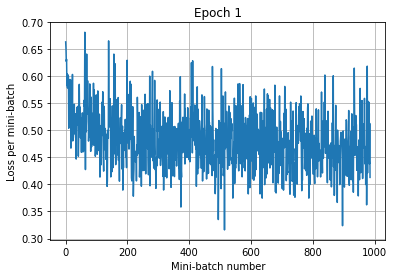


Validation:
Epoch: 1
Loss = 0.467, accuracy = 0.786, speed = 5849 pps


In [208]:
X = np.stack(df_all['text_list'])
y = df_all['search_query'].values

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=_RANDOM_SEED)
def shuffling(X, y):
    p = np.random.permutation(X.shape[0])
    return X[p], y[p]

with tf.Session() as sess:
    print('Training:')
    vector_reps, y = run_model(sess, X_train, y_train, lr_decay=lr_decay, is_training=True, nb_epochs=1)
    print('\nValidation:')
    run_model(sess, X_valid, y_valid, is_training=False, nb_epochs=1)

In [56]:
for i in range(30):
    index = np.random.randint(df_all.shape[0])
    print(df_all['search_query'][index])
    print(df_all['text'][index])
    print('\n')

0
New trending GIF tagged happy, smile, reactions, hair via Giphy http://ift.tt/19p0lFO


3
Sudden fever and stomach ache… not sure if this is just residual from being dehydrated and stressed or if I’ve caught something bad…


3
New GIF tagged cat, scared, banana via Giphy http://ift.tt/1rKGfgC


0
it’s another rainy Monday so here’s me in my little nest


0
Today is the day I choose to be happy for me. For no one else, I will be positive, I will make myself into what I want.


3
I’m too scared to show the real me


0
Have a great day back to school/ work everyone!


0
having a hoodie + blanket from jake is so good especially at night cause like it smells like him and its like getting a nice big hug as im going to sleep 10/10 would recommend


2
#stressed #tired #angry #nevergivingup Life gets hard, but with will power, strength, and determination your goals will be met. #Igotthis #hanginthere #scorpion #DjC4nnon


2
I am sad, disappointed and annoyed. The best solution - GYM. But hone

In [51]:
emotion_dict

{'angry': 2, 'disgusted': 4, 'happy': 0, 'sad': 1, 'scared': 3, 'surprised': 5}

In [191]:
X_sklearn = np.vstack(vector_reps)
y_sklearn = y.T.reshape((-1))

In [192]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
_RANDOM_SEED = 0

In [193]:
X_sklearn_train, X_sklearn_test, y_sklearn_train, y_sklearn_test = train_test_split(X_sklearn, y_sklearn, 
                                                                                    test_size=0.2,
                                                                                    random_state=_RANDOM_SEED)

In [194]:
logreg = LogisticRegression()
logreg.fit(X_sklearn_train, y_sklearn_train)
print(accuracy_score(logreg.predict(X_sklearn_train), y_sklearn_train))
print(accuracy_score(logreg.predict(X_sklearn_test), y_sklearn_test))

0.765537506237
0.765309678441


In [198]:
forest = RandomForestClassifier(max_depth=15)
forest.fit(X_sklearn_train, y_sklearn_train)
print(accuracy_score(forest.predict(X_sklearn_train), y_sklearn_train))
print(accuracy_score(forest.predict(X_sklearn_test), y_sklearn_test))

0.910667754378
0.762806906384
